In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [36]:
outage_capacity = pd.read_csv('data/sample/ercot/NP3-233-CD/2025/12/NP3-233-CD_202512.csv')
load_forecast = pd.read_csv('data/sample/ercot/NP3-565-CD/2025/12/NP3-565-CD_202512.csv')
renewable_detail = pd.read_csv('data/sample/ercot/NP3-911-ER/2025/12/NP3-911-ER_202512.csv')
DAM_ancillary_prices = pd.read_csv('data/sample/ercot/NP4-188-CD/2025/12/NP4-188-CD_202512.csv')
DAM_system_lambda = pd.read_csv('data/sample/ercot/NP4-523-CD/2025/12/NP4-523-CD_202512.csv')
wind = pd.read_csv('data/sample/ercot/NP4-732-CD/2025/12/NP4-732-CD_202512.csv')
solar = pd.read_csv('data/sample/ercot/NP4-745-CD/2025/12/NP4-745-CD_202512.csv')
RT_ancillary_prices = pd.read_csv('data/sample/ercot/NP6-331-CD/2025/12/NP6-331-CD_202512.csv')
load_actual = pd.read_csv('data/sample/ercot/NP6-346-CD/2025/12/NP6-346-CD_202512.csv')
LMP_detail = pd.read_csv('data/sample/ercot/NP6-788-CD/2025/12/NP6-788-CD_202512.csv')
settlement_prices = pd.read_csv('data/sample/ercot/NP6-905-CD/2025/12/NP6-905-CD_202512.csv')

## Initial Experiments with Outage Capacity ##
We eventually build a time series plot for each of the three Houston columns, as well as the sum of those three columns. Since multiple (nearby) data points exist for each hour, we average them before doing anything else. (It turns out that this is due to making predictions up to a week in advance, so maybe averaging isn't the best approach.)

The sum describes the aggregated outaged capacity of all the active resource outages, except resource outages for retirement of old equipment, seasonal mothballed (during the outaged season), and mothballed.

In [37]:
outage_capacity.head(5)

,Date,HourEnding,TotalResourceMWZoneSouth,TotalResourceMWZoneNorth,TotalResourceMWZoneWest,TotalResourceMWZoneHouston,TotalIRRMWZoneSouth,TotalIRRMWZoneNorth,TotalIRRMWZoneWest,TotalIRRMWZoneHouston,TotalNewEquipResourceMWZoneSouth,TotalNewEquipResourceMWZoneNorth,TotalNewEquipResourceMWZoneWest,TotalNewEquipResourceMWZoneHouston
0,11/30/2025,24,9525,5647,664,3213,714,926,1974,163,1093,2760,1385,1256
1,11/30/2025,24,9525,5703,664,3213,714,926,1974,163,1093,2760,1385,1256
2,11/30/2025,24,9525,5703,664,3168,714,926,1974,163,1093,2760,1385,1256
3,11/30/2025,24,9525,5703,664,3213,714,926,1974,163,1093,2760,1385,1256
4,11/30/2025,24,9525,5703,664,3213,714,926,1965,163,1093,2760,1385,1256


In [38]:
outage_capacity["Datetime"] = (
    pd.to_datetime(outage_capacity["Date"], format="%m/%d/%Y")
    + pd.to_timedelta(outage_capacity["HourEnding"]-1, unit="h")
)

In [39]:
outage_capacity = outage_capacity.drop(columns=['Date', 'HourEnding'])

In [40]:
to_drop = []
for s in ('TotalResourceMW', 'TotalIRRMW', 'TotalNewEquipResourceMW'):
    for t in ('South', 'North', 'West'):
        to_drop.append(s + 'Zone' + t)
outage_capacity = outage_capacity.drop(columns=to_drop)

In [41]:
## Some hours have a lot more data than others
## It looks like a lot of them have 24*n or 24*n-1 data points for n = 1, ..., 8
outage_capacity['Datetime'].value_counts().tail(50)

Datetime
2026-01-06 21:00:00    47
2026-01-06 22:00:00    47
2025-11-30 23:00:00    24
2025-12-01 00:00:00    24
2025-12-01 01:00:00    24
2025-12-01 02:00:00    24
2025-12-01 03:00:00    24
2025-12-01 04:00:00    24
2025-12-01 05:00:00    24
2025-12-01 06:00:00    24
2025-12-01 07:00:00    24
2025-12-01 08:00:00    24
2025-12-01 09:00:00    24
2025-12-01 10:00:00    24
2025-12-01 11:00:00    24
2025-12-01 12:00:00    24
2025-12-01 13:00:00    24
2025-12-01 14:00:00    24
2025-12-01 15:00:00    24
2025-12-01 16:00:00    24
2025-12-01 17:00:00    24
2025-12-01 18:00:00    24
2025-12-01 19:00:00    24
2025-12-01 20:00:00    24
2025-12-01 21:00:00    24
2025-12-01 22:00:00    24
2026-01-06 23:00:00    23
2026-01-07 00:00:00    23
2026-01-07 01:00:00    23
2026-01-07 02:00:00    23
2026-01-07 03:00:00    23
2026-01-07 04:00:00    23
2026-01-07 05:00:00    23
2026-01-07 06:00:00    23
2026-01-07 07:00:00    23
2026-01-07 08:00:00    23
2026-01-07 09:00:00    23
2026-01-07 10:00:00    23
202

In [42]:
outage_capacity_avg = (
    outage_capacity
    .groupby("Datetime", as_index=True)
    .mean()
)

In [43]:
outage_capacity_avg.head()

,TotalResourceMWZoneHouston,TotalIRRMWZoneHouston,TotalNewEquipResourceMWZoneHouston
Datetime,,,
2025-11-30 23:00:00,3210.625,164.041667,1249.333333
2025-12-01 00:00:00,3210.625,164.041667,1249.333333
2025-12-01 01:00:00,3210.625,163.000000,1249.333333
2025-12-01 02:00:00,3210.625,163.000000,1249.333333
2025-12-01 03:00:00,3210.625,163.000000,1249.333333


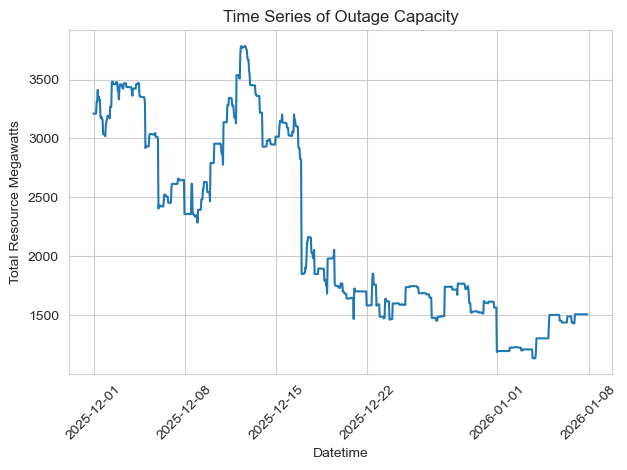

In [44]:
plt.figure()
plt.plot(outage_capacity_avg.index, outage_capacity_avg["TotalResourceMWZoneHouston"])
plt.xlabel("Datetime")
plt.ylabel("Total Resource Megawatts")
plt.title("Time Series of Outage Capacity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## The following shows Outage Capacity, excluding outages related to:
##  • retirement of old equipment
##  • mothballed equipment
##  • intermittent renewable resources (wind & solar)
##  • new equipment outages

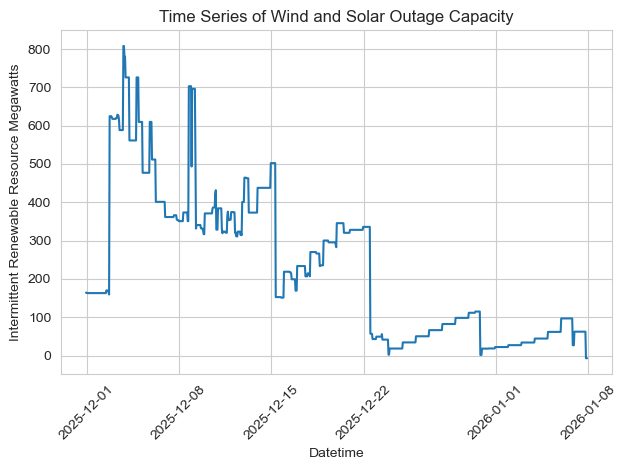

In [45]:
plt.figure()
plt.plot(outage_capacity_avg.index, outage_capacity_avg["TotalIRRMWZoneHouston"])
plt.xlabel("Datetime")
plt.ylabel("Intermittent Renewable Resource Megawatts")
plt.title("Time Series of Wind and Solar Outage Capacity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## The following shows Outage Capacity of intermittent renewable resources

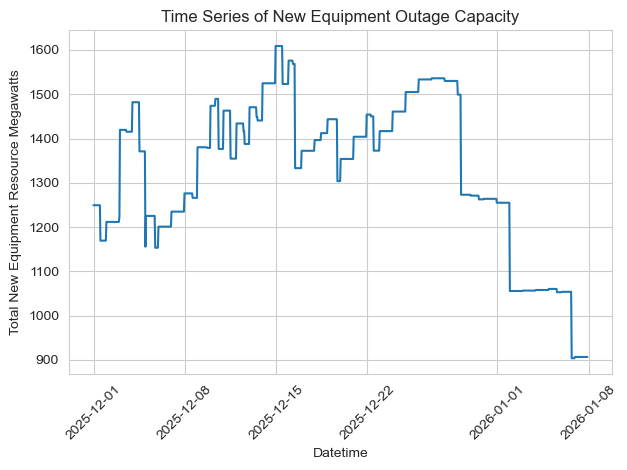

In [46]:
plt.figure()
plt.plot(outage_capacity_avg.index, outage_capacity_avg["TotalNewEquipResourceMWZoneHouston"])
plt.xlabel("Datetime")
plt.ylabel("Total New Equipment Resource Megawatts")
plt.title("Time Series of New Equipment Outage Capacity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## The following shows Outage Capacity due to new equipment outages

In [47]:
outage_capacity_avg = outage_capacity_avg.rename(
    columns={
        'TotalResourceMWZoneHouston' : 'Other',
        'TotalIRRMWZoneHouston' : 'Intermittent_Renewable',
        'TotalNewEquipResourceMWZoneHouston': 'New_Equipment'
    }
)

In [48]:
outage_capacity_avg['Total'] = outage_capacity_avg[['Other', 'Intermittent_Renewable', 'New_Equipment']].sum(axis=1)

In [49]:
outage_capacity_avg.head()

,Other,Intermittent_Renewable,New_Equipment,Total
Datetime,,,,
2025-11-30 23:00:00,3210.625,164.041667,1249.333333,4624.000000
2025-12-01 00:00:00,3210.625,164.041667,1249.333333,4624.000000
2025-12-01 01:00:00,3210.625,163.000000,1249.333333,4622.958333
2025-12-01 02:00:00,3210.625,163.000000,1249.333333,4622.958333
2025-12-01 03:00:00,3210.625,163.000000,1249.333333,4622.958333


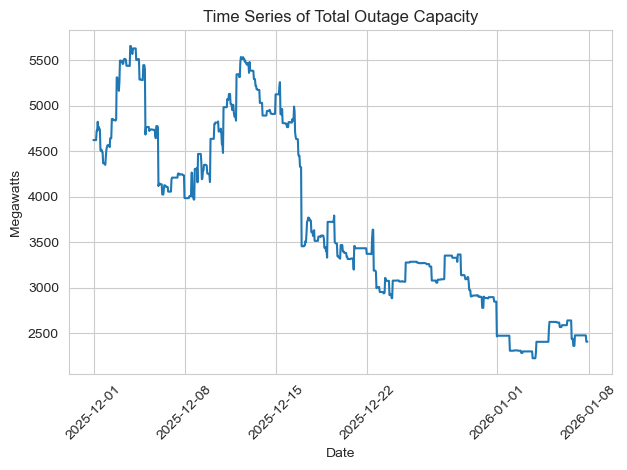

In [50]:
plt.figure()
plt.plot(outage_capacity_avg.index, outage_capacity_avg["Total"])
plt.xlabel("Date")
plt.ylabel("Megawatts")
plt.title("Time Series of Total Outage Capacity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Total time series data:

## Checking for relationships ##
Now that we understand the structure of our data a little bit better, let's see if we can build one unified dataframe to account for all the data at hand

In [51]:
outage_capacity = pd.read_csv('data/sample/ercot/NP3-233-CD/2025/12/NP3-233-CD_202512.csv')
load_forecast = pd.read_csv('data/sample/ercot/NP3-565-CD/2025/12/NP3-565-CD_202512.csv')
renewable_detail = pd.read_csv('data/sample/ercot/NP3-911-ER/2025/12/NP3-911-ER_202512.csv')
DAM_ancillary_prices = pd.read_csv('data/sample/ercot/NP4-188-CD/2025/12/NP4-188-CD_202512.csv')
DAM_system_lambda = pd.read_csv('data/sample/ercot/NP4-523-CD/2025/12/NP4-523-CD_202512.csv')
wind = pd.read_csv('data/sample/ercot/NP4-732-CD/2025/12/NP4-732-CD_202512.csv')
solar = pd.read_csv('data/sample/ercot/NP4-745-CD/2025/12/NP4-745-CD_202512.csv')
RT_ancillary_prices = pd.read_csv('data/sample/ercot/NP6-331-CD/2025/12/NP6-331-CD_202512.csv')
load_actual = pd.read_csv('data/sample/ercot/NP6-346-CD/2025/12/NP6-346-CD_202512.csv')
LMP_detail = pd.read_csv('data/sample/ercot/NP6-788-CD/2025/12/NP6-788-CD_202512.csv')
settlement_prices = pd.read_csv('data/sample/ercot/NP6-905-CD/2025/12/NP6-905-CD_202512.csv')

In [52]:
dfs = [outage_capacity, load_forecast, renewable_detail, DAM_ancillary_prices, DAM_system_lambda, wind, solar, RT_ancillary_prices, load_actual, LMP_detail, settlement_prices]

### Outage Capacity ###
As above, this is separated by Load Zone, so we'll keep only the Houston entries and average the predictions across the previous 7 days. Not a great solution, but it's all we can do for now.

In [53]:
outage_capacity = pd.read_csv('data/sample/ercot/NP3-233-CD/2025/12/NP3-233-CD_202512.csv')
print(outage_capacity.columns)

Index(['Date', 'HourEnding', 'TotalResourceMWZoneSouth',
       'TotalResourceMWZoneNorth', 'TotalResourceMWZoneWest',
       'TotalResourceMWZoneHouston', 'TotalIRRMWZoneSouth',
       'TotalIRRMWZoneNorth', 'TotalIRRMWZoneWest', 'TotalIRRMWZoneHouston',
       'TotalNewEquipResourceMWZoneSouth', 'TotalNewEquipResourceMWZoneNorth',
       'TotalNewEquipResourceMWZoneWest',
       'TotalNewEquipResourceMWZoneHouston'],
      dtype='str')


In [54]:
outage_capacity["Datetime"] = (
    pd.to_datetime(outage_capacity["Date"], format="%m/%d/%Y")
    + pd.to_timedelta(outage_capacity["HourEnding"]-1, unit="h")
)

to_drop = ['Date', 'HourEnding']
for s in ('TotalResourceMW', 'TotalIRRMW', 'TotalNewEquipResourceMW'):
    for t in ('South', 'North', 'West'):
        to_drop.append(s + 'Zone' + t)
outage_capacity = outage_capacity.drop(columns=to_drop)

outage_capacity = outage_capacity.rename(
    columns={
        'TotalResourceMWZoneHouston' : 'Other_Outage',
        'TotalIRRMWZoneHouston' : 'Intermittent_Renewable_Outage',
        'TotalNewEquipResourceMWZoneHouston': 'New_Equipment_Outage'
    }
)

outage_capacity = (
    outage_capacity
    .groupby("Datetime", as_index=True)
    .mean()
)

In [55]:
outage_capacity.head()

,Other_Outage,Intermittent_Renewable_Outage,New_Equipment_Outage
Datetime,,,
2025-11-30 23:00:00,3210.625,164.041667,1249.333333
2025-12-01 00:00:00,3210.625,164.041667,1249.333333
2025-12-01 01:00:00,3210.625,163.000000,1249.333333
2025-12-01 02:00:00,3210.625,163.000000,1249.333333
2025-12-01 03:00:00,3210.625,163.000000,1249.333333


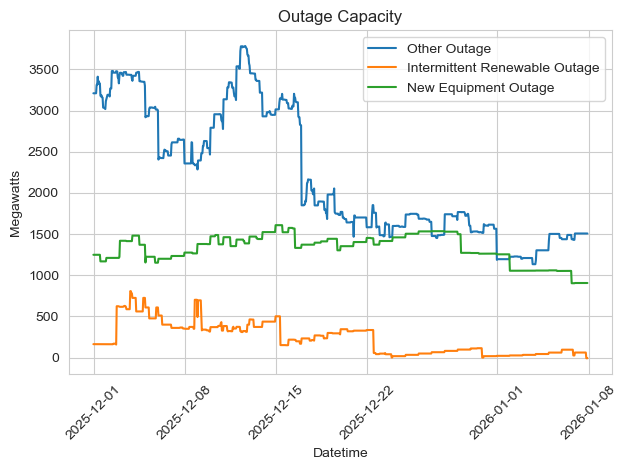

In [56]:
plt.figure()

plt.plot(outage_capacity.index, outage_capacity["Other_Outage"], label="Other Outage")
plt.plot(outage_capacity.index, outage_capacity["Intermittent_Renewable_Outage"], label="Intermittent Renewable Outage")
plt.plot(outage_capacity.index, outage_capacity["New_Equipment_Outage"], label="New Equipment Outage")

plt.xlabel("Datetime")
plt.ylabel("Megawatts")
plt.title("Outage Capacity")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Load Forecast ###
This is separated by weather region, so we'll use Coast since it mostly coincides with the Houston Load Zone. We will also use only the forecasts by models which were in use by ERCOT at the time.

In [57]:
load_forecast = pd.read_csv('data/sample/ercot/NP3-565-CD/2025/12/NP3-565-CD_202512.csv')

load_forecast['HourEnding'] = load_forecast['HourEnding'].apply(lambda x: int(str(x).split(':')[0]))

load_forecast["Datetime"] = (
    pd.to_datetime(load_forecast["DeliveryDate"], format="%m/%d/%Y")
    + pd.to_timedelta(load_forecast["HourEnding"]-1, unit="h")
)

load_forecast = load_forecast[load_forecast['InUseFlag'] == 'Y']

to_drop = ['DeliveryDate', 'HourEnding', 'East', 'FarWest', 'North',
           'NorthCentral', 'SouthCentral', 'Southern', 'West',
           'SystemTotal', 'Model', 'InUseFlag', 'DSTFlag']
load_forecast = load_forecast.drop(columns=to_drop)

load_forecast = load_forecast.rename(
    columns={
        'Coast' : 'load_forecast'
    }
)

load_forecast = (
    load_forecast
    .groupby("Datetime", as_index=True)
    .mean()
)

In [58]:
load_forecast.head(5)

,load_forecast
Datetime,
2025-12-01 00:00:00,11019.299800
2025-12-01 01:00:00,10682.612300
2025-12-01 02:00:00,10459.283700
2025-12-01 03:00:00,10675.328975
2025-12-01 04:00:00,10968.658492


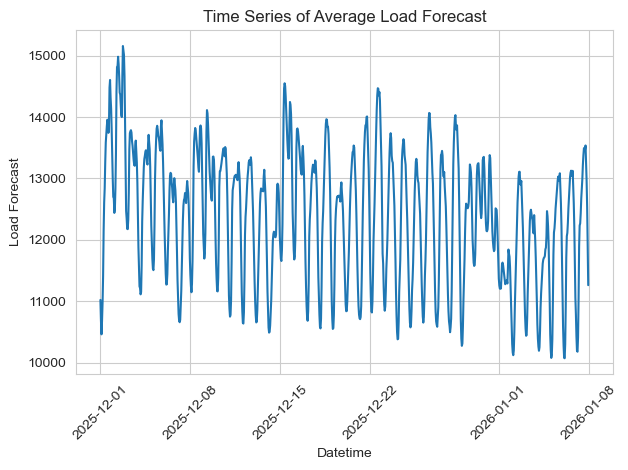

In [59]:
plt.figure()
plt.plot(load_forecast.index, load_forecast["load_forecast"])
plt.xlabel("Datetime")
plt.ylabel("Load Forecast")
plt.title("Time Series of Average Load Forecast")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

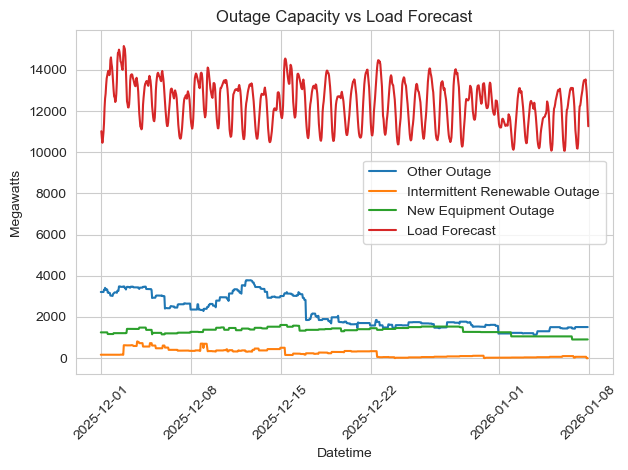

In [60]:
plt.figure()

plt.plot(outage_capacity.index, outage_capacity["Other_Outage"], label="Other Outage")
plt.plot(outage_capacity.index, outage_capacity["Intermittent_Renewable_Outage"], label="Intermittent Renewable Outage")
plt.plot(outage_capacity.index, outage_capacity["New_Equipment_Outage"], label="New Equipment Outage")
plt.plot(load_forecast.index, load_forecast["load_forecast"], label="Load Forecast")

plt.xlabel("Datetime")
plt.ylabel("Megawatts")
plt.title("Outage Capacity vs Load Forecast")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Renewable Detail ###
We're missing a lot of data here, so I'll table this for now.

In [61]:
renewable_detail = pd.read_csv('data/sample/ercot/NP3-911-ER/2025/12/NP3-911-ER_202512.csv')

### Day-Ahead Market Ancillary Prices ###
Market Clearing Prices for Capacity for all Ancillary Services.
The hourly prices for the following day are posted once per day around 4am. We want to treat this as information from the day of posting, so we will subtract one day from the time.

In [62]:
DAM_ancillary_prices = pd.read_csv('data/sample/ercot/NP4-188-CD/2025/12/NP4-188-CD_202512.csv')

DAM_ancillary_prices['HourEnding'] = DAM_ancillary_prices['HourEnding'].apply(lambda x: int(str(x).split(':')[0]))

DAM_ancillary_prices["Datetime"] = (
    pd.to_datetime(DAM_ancillary_prices["DeliveryDate"], format="%m/%d/%Y")
    + pd.to_timedelta(DAM_ancillary_prices["HourEnding"]-1, unit="h")
)

DAM_ancillary_prices["Datetime"] = DAM_ancillary_prices["Datetime"].apply(lambda x: x - pd.Timedelta(days=1))

DAM_ancillary_prices = DAM_ancillary_prices.pivot(
    index="Datetime",
    columns="AncillaryType",
    values="MCPC"
).rename_axis(None, axis=1)

DAM_ancillary_prices = DAM_ancillary_prices.rename(lambda col : col + '_MCPC_from_DAM', axis=1)

In [63]:
DAM_ancillary_prices.head(5)

,ECRS_MCPC_from_DAM,NSPIN_MCPC_from_DAM,REGDN_MCPC_from_DAM,REGUP_MCPC_from_DAM,RRS_MCPC_from_DAM
Datetime,,,,,
2025-12-01 00:00:00,4.99,4.99,1.00,5.69,4.99
2025-12-01 01:00:00,1.03,1.06,1.12,1.44,1.06
2025-12-01 02:00:00,0.89,3.00,1.44,1.60,0.89
2025-12-01 03:00:00,0.30,1.56,1.33,1.20,0.30
2025-12-01 04:00:00,0.30,2.00,1.68,1.20,0.30


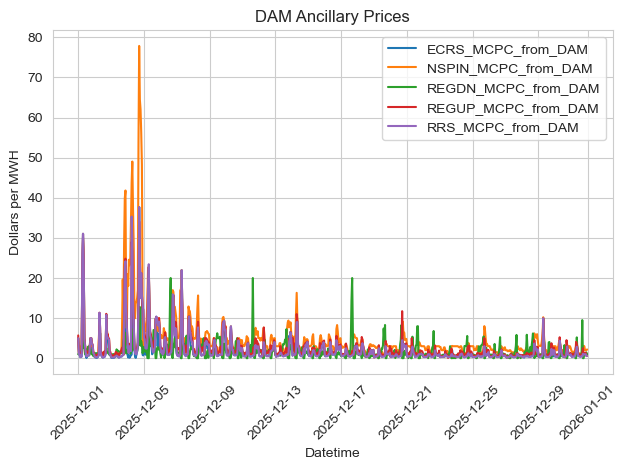

In [64]:
plt.figure()

for col in DAM_ancillary_prices:
    plt.plot(DAM_ancillary_prices.index, DAM_ancillary_prices[col], label=col)

plt.xlabel("Datetime")
plt.ylabel("Dollars per MWH")
plt.title("DAM Ancillary Prices")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

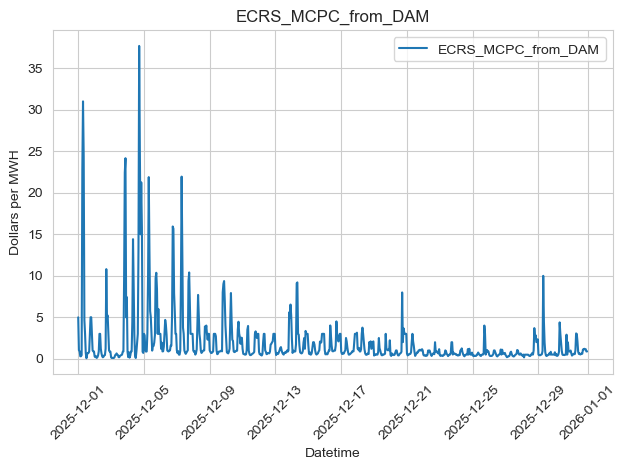

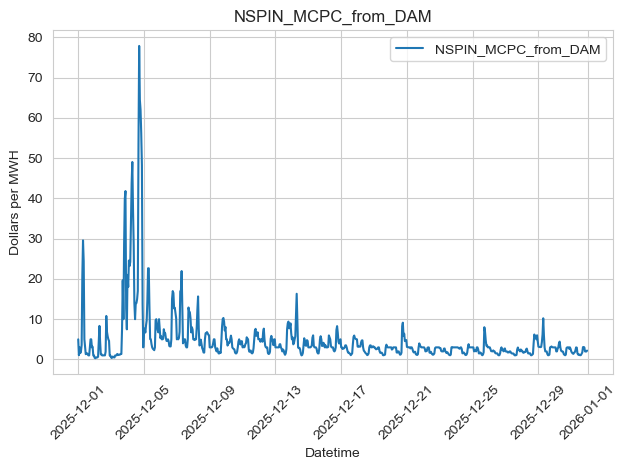

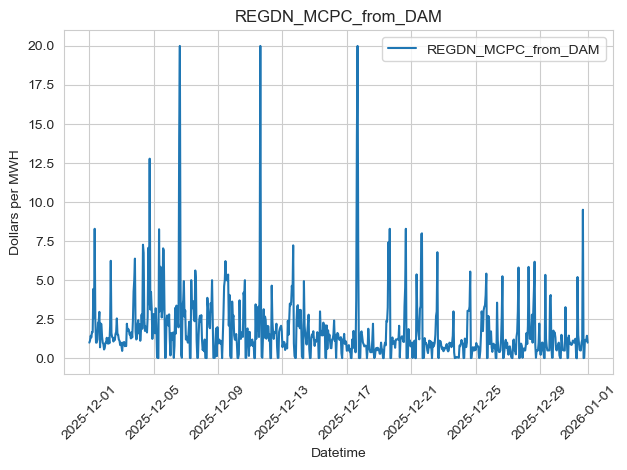

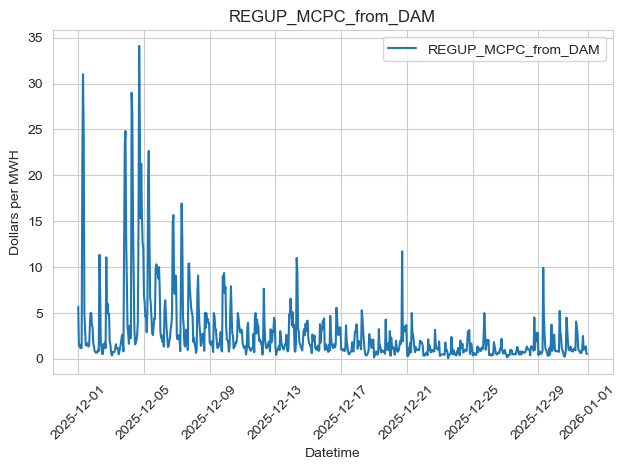

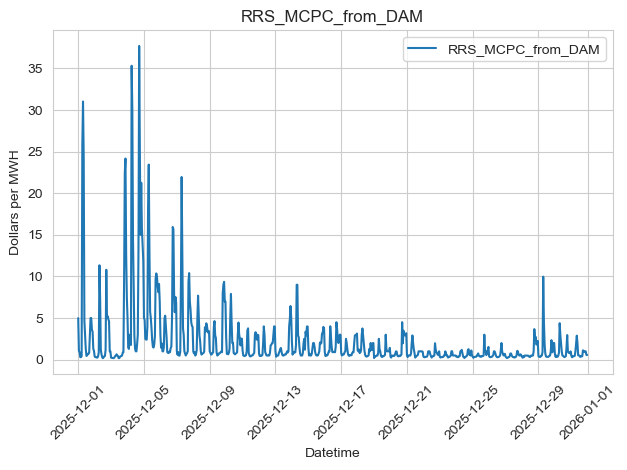

In [65]:
for col in DAM_ancillary_prices:
    plt.figure()
    plt.plot(DAM_ancillary_prices.index, DAM_ancillary_prices[col], label=col)
    plt.xlabel("Datetime")
    plt.ylabel("Dollars per MWH")
    plt.title(col)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

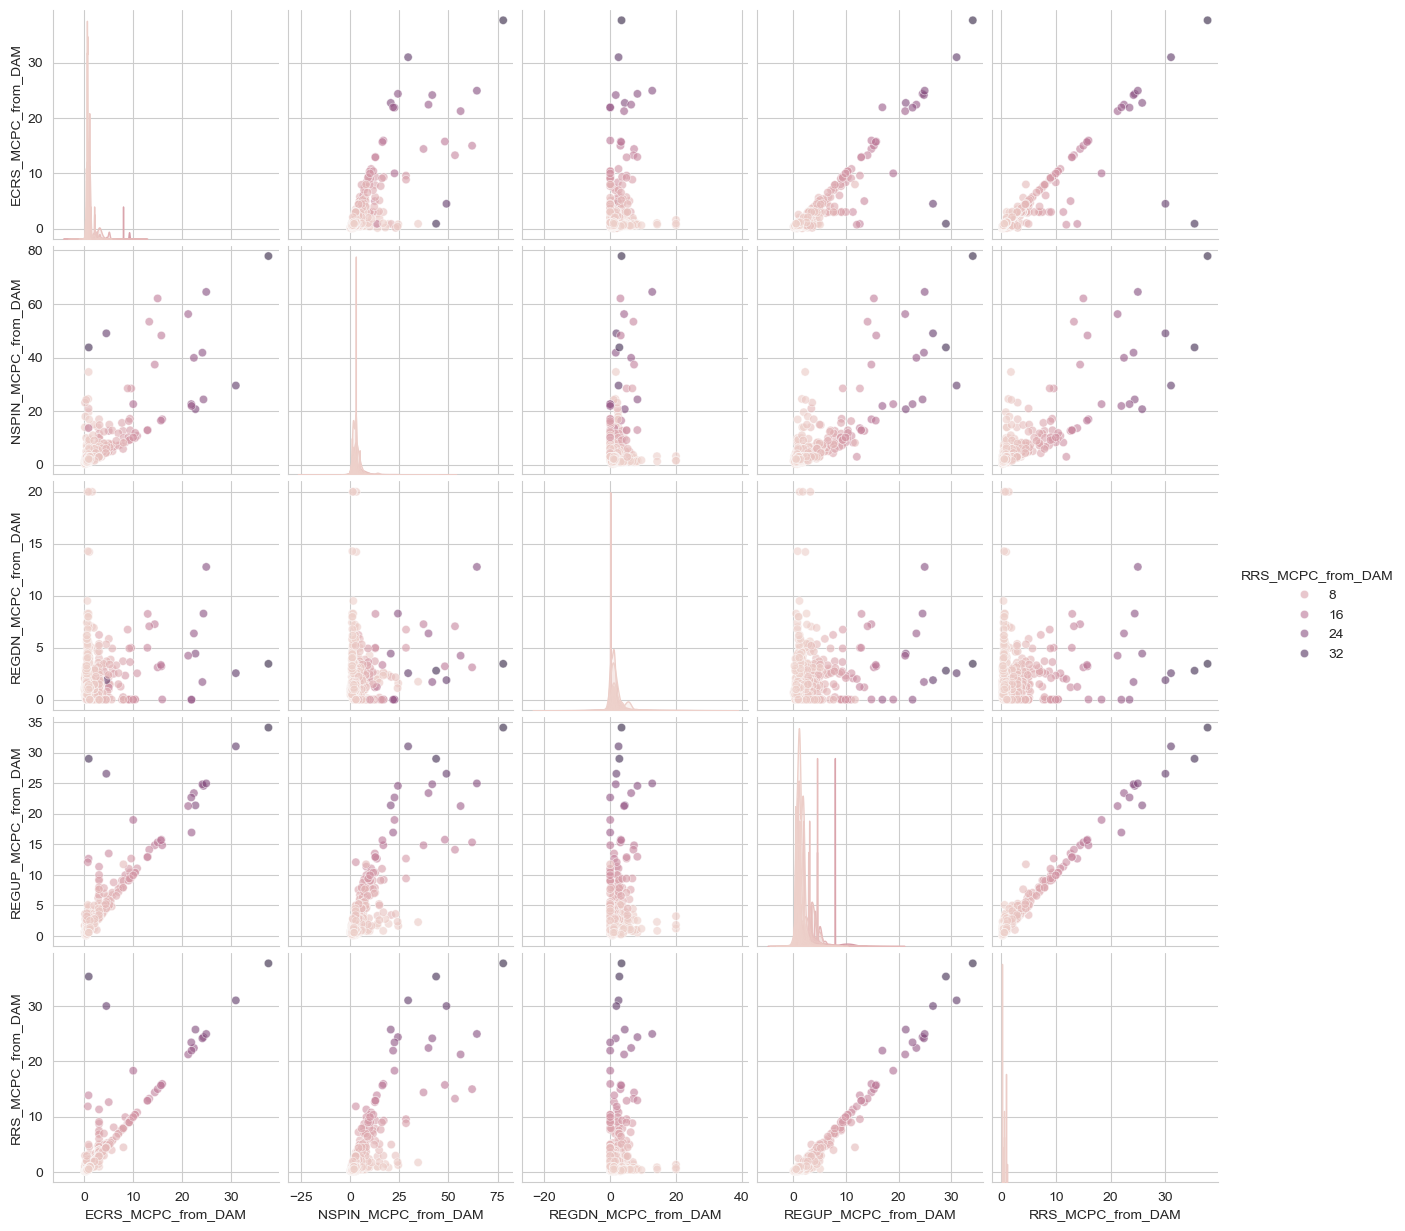

In [66]:
sns.pairplot(data = DAM_ancillary_prices,
                x_vars = DAM_ancillary_prices.columns,
                y_vars = DAM_ancillary_prices.columns,
                hue = DAM_ancillary_prices.columns[-1],
                plot_kws = {'alpha':.6})

plt.show()